<a href="https://colab.research.google.com/github/noobnoob61/DeepLearning/blob/main/NLP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv


--2025-01-15 15:11:05--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.09s   

2025-01-15 15:11:06 (5.35 MB/s) - ‘spam.csv’ saved [503663/503663]



In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
# tiny dataset

sentences = [
    "I like eggs and ham.",
    "I love chocolate and bunnies.",
    "I hate onions."
]

In [ ]:
MAX_VOCAB_SIZE=20_000


In [ ]:
vectorization_layer=TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    # standardize="lower_and_strip_punctuation",
    # split="whitespace",
    # output_mode='int',            #default

)

In [ ]:
vectorization_layer.adapt(sentences) # fit

In [ ]:
sequences = vectorization_layer(sentences)  # predict

print(sequences)

tf.Tensor(
[[ 2  6  9  3  8]
 [ 2  5 10  3 11]
 [ 2  7  4  0  0]], shape=(3, 5), dtype=int64)


In [ ]:
vectorization_layer.get_vocabulary()

['',
 '[UNK]',
 'i',
 'and',
 'onions',
 'love',
 'like',
 'hate',
 'ham',
 'eggs',
 'chocolate',
 'bunnies']

In [ ]:
# word to word index mapping

for k in enumerate(vectorization_layer.get_vocabulary()):
   print(k)

(0, '')
(1, '[UNK]')
(2, 'i')
(3, 'and')
(4, 'onions')
(5, 'love')
(6, 'like')
(7, 'hate')
(8, 'ham')
(9, 'eggs')
(10, 'chocolate')
(11, 'bunnies')


In [ ]:
# truncation
vectorization_layer_truncated = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=3
)

#fit

vectorization_layer_truncated.adapt(sentences)

# vectorize

sequences_truncated = vectorization_layer_truncated(sentences)

print(sequences_truncated)

tf.Tensor(
[[ 2  6  9]
 [ 2  5 10]
 [ 2  7  4]], shape=(3, 3), dtype=int64)


In [ ]:
# truncation embedding padding

In [ ]:
# ragged (no padding)
vectorization_layer_ragged= TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    ragged=True
)

# fit

vectorization_layer_ragged.adapt(sentences)

# vectorize

sequences_ragged = vectorization_layer_ragged(sentences)

print(sequences_ragged)


<tf.RaggedTensor [[2, 6, 9, 3, 8], [2, 5, 10, 3, 11], [2, 7, 4]]>


In [ ]:
sequences_ragged.to_list() # to make it iterable

[[2, 6, 9, 3, 8], [2, 5, 10, 3, 11], [2, 7, 4]]

In [ ]:
# pad at front instead of back
# not supported in Text Vectorization layer itself
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences

# defaults:

#   tf.keras.utils.pad_sequences(
#       sequences,
#       maxlen=None,
#       dtype='int32',
#       padding='pre',
#       truncating='pre',
#       value=0.0
#   )

padded= pad_sequences(sequences_ragged.to_list())
print(padded)


[[ 2  6  9  3  8]
 [ 2  5 10  3 11]
 [ 0  0  2  7  4]]


## Classification using LSTM (spam detection)


In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input , GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding ,TextVectorization
from tensorflow.keras.models import Model

In [ ]:
df= pd.read_csv("spam.csv",encoding="ISO-8859-1")

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df=df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.columns=['labels','data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# create binary labels

df['b_labels']=df['labels'].map({'ham':0,'spam':1})
Y=df['b_labels'].values

In [ ]:
y


array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(df['data'],y,test_size=0.33)

In [ ]:
# create tf datasets

train_ds = tf.data.Dataset.from_tensor_slices((x_train.values,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test.values,y_test))


In [ ]:
MAX_VOCAB_SIZE=20_000

vectorization=TextVectorization(max_tokens=MAX_VOCAB_SIZE)
vectorization.adapt(train_ds.map(lambda x,y:x))

In [ ]:
#shuffle and batch the dataset

train_ds= train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
V=len(vectorization.get_vocabulary())
V

7585

In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M=15

# if string not specified, will get string -> float casting error
i=Input(shape=(1,),dtype=tf.string,name='Text')
x=vectorization(i)
x=Embedding(V,D)(x)
x=LSTM(M,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(i,x)


In [ ]:
# Compile and fit

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print('Training model...')
r=model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Training model...
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8675 - loss: 0.4787 - val_accuracy: 0.8760 - val_loss: 0.3223
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9166 - loss: 0.2218 - val_accuracy: 0.9875 - val_loss: 0.0831
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9887 - loss: 0.0780 - val_accuracy: 0.9891 - val_loss: 0.0576
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9947 - loss: 0.0473 - val_accuracy: 0.9891 - val_loss: 0.0540
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9953 - loss: 0.0381 - val_accuracy: 0.8189 - val_loss: 0.3419
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9518 - loss: 0.1080 - val_accuracy: 0.9772 - val_loss: 0.0722
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9962 - loss: 0.0296 - val_accuracy: 0.9799 - val_loss: 0.0664
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9962 - loss:

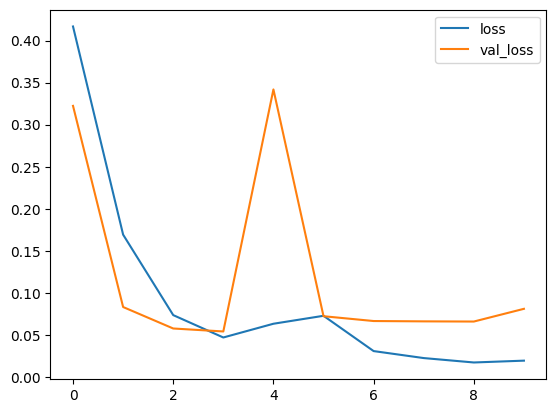

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

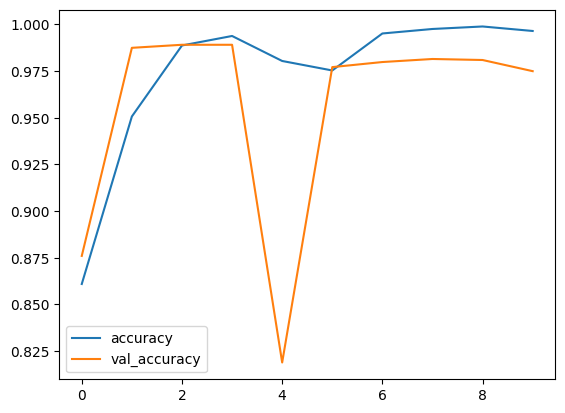

In [ ]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

<Axes: >

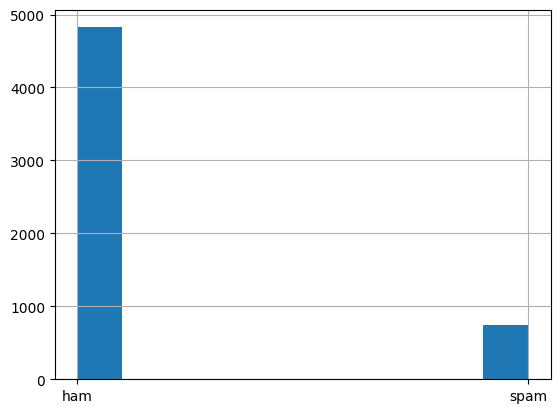

In [ ]:
df['labels'].hist()

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train,model.predict(x_train.values)>0.5)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


0.9932756964457252

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,model.predict(x_test.values)>0.5)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


0.9049586776859504

In [ ]:
# its better not to pass raw string (integers are better)in our neural netwoork

train_ints= vectorization(x_train.values)
test_ints= vectorization(x_test.values)

In [ ]:
train_ints.shape

TensorShape([3733, 171])

In [ ]:
train_ints[:5]

<tf.Tensor: shape=(5, 171), dtype=int64, numpy=
array([[2001,    3,  271,    6, 1583, 1460,   51, 3824,   17, 4869,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [ ]:


train_ds = tf.data.Dataset.from_tensor_slices((train_ints,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((test_ints,y_test))



In [ ]:

train_ds= train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M=15

# if string not specified, will get string -> float casting error
i=Input(shape=(None,))
x=Embedding(V,D)(i)
x=LSTM(M,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(i,x)

In [ ]:
# Compile and fit

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print('Training model...')
r=model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Training model...
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.8557 - loss: 0.5185 - val_accuracy: 0.8760 - val_loss: 0.3521
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.8964 - loss: 0.2776 - val_accuracy: 0.9657 - val_loss: 0.1205
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.9849 - loss: 0.1010 - val_accuracy: 0.9848 - val_loss: 0.0707
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9905 - loss: 0.0714 - val_accuracy: 0.9712 - val_loss: 0.0846
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9941 - loss: 0.0491 - val_accuracy: 0.9875 - val_loss: 0.0576
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9965 - loss: 0.0332 - val_accuracy: 0.9875 - val_loss: 0.0550
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9964 - loss: 0.0330 - val_accuracy: 0.9880 - val_loss: 0.0536
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9963 -

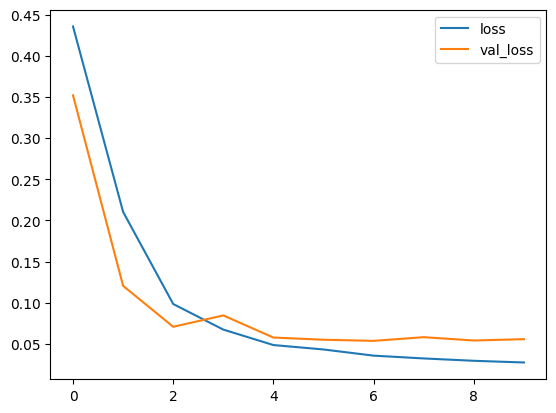

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

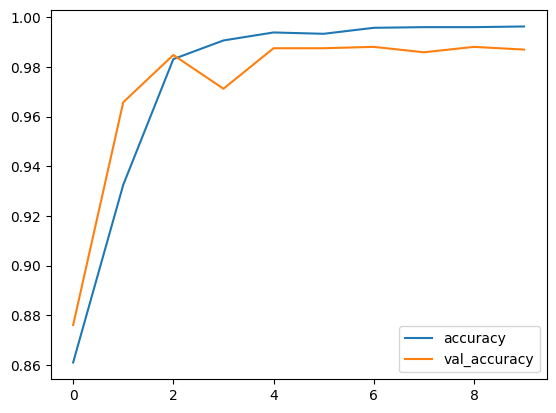

In [ ]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()